In [19]:
# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import ML libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, f1_score, plot_precision_recall_curve, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#import bootstrap libs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

#dummy classifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

In [20]:
# Load data
train_merged = pd.read_csv('../data/train_street_merged.csv')
test_merged = pd.read_csv('../data/test_street_merged.csv')
pd.set_option('display.max_columns',99)

In [21]:
train_merged.head(1)

,date,latitude,longitude,nummosquitos,wnvpresent,street_ W ARMITAGE AVENUE,street_ E 105TH ST,street_ E 111TH ST,street_ E 115TH ST,street_ E 118TH ST,street_ E 130TH ST,street_ E 138TH ST,street_ E 67TH ST,street_ E 91ST PL,street_ E 91ST ST,street_ E RANDOLPH ST,street_ N ASHLAND AVE,street_ N ASHLAND AVE OVERPASS,street_ N AUSTIN AVE,street_ N AVONDALE AVE,street_ N CALIFORNIA AVE,street_ N CAMPBELL AVE,street_ N CANNON DR,street_ N CENTRAL PARK DR,street_ N FRANCISCO AVE,street_ N HARLEM AVE,street_ N HUMBOLDT DR,street_ N KEDVALE AVE,street_ N LARAMIE AVE,street_ N LAWLER AVE,street_ N LEMONT AVE,street_ N LONG AVE,street_ N MANDELL AVE,street_ N MCCLELLAN AVE,street_ N MILWAUKEE AVE,street_ N MONT CLARE AVE,street_ N MOSELL AVE,street_ N OAK PARK AVE,street_ N OAKLEY AVE,street_ N OKETO AVE,street_ N PITTSBURGH AVE,street_ N PULASKI RD,street_ N RICHMOND ST,street_ N RIDGE AVE,street_ N RUTHERFORD AVE,street_ N SPRINGFIELD AVE,street_ N STAVE ST,street_ N STREETER DR,street_ N TRIPP AVE,...,street_ W FULLERTON AVE,street_ W GARFIELD BLVD,street_ W GRAND AVE,street_ W GRANVILLE AVE,street_ W GREENLEAF AVE,street_ W HIGGINS AVE,street_ W HIGGINS RD,street_ W LELAND AVE,street_ W MONTANA ST,street_ W MONTROSE DR,street_ W OHARE,street_ W OHARE AIRPORT,street_ W PERSHING RD,street_ W ROOSEVELT,street_ W ROSCOE ST,street_ W STRONG ST,street_ W SUNNYSIDE AVE,street_ W WEBSTER AVE,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,daylightmins,tminsq,tmaxsq,tavgsq,departsq,wetbulbsq,heatsq,coolsq,preciptotalsq,resultspeedsq,resultdirsq,avgspeedsq,daylightminssq,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHERS
0,2007-05-29,41.95469,-87.800991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,896.0,3600.0,7744.0,5476.0,100.0,4225.0,0.0,81.0,0.0,33.64,324.0,42.25,802816.0,0,1,0,0


## Baseline Model

In [22]:
#define X, y
X = train_merged.drop(columns = ['wnvpresent','date','nummosquitos'])
y = train_merged['wnvpresent']

In [23]:
baseline = y.value_counts(normalize=True)

In [24]:
print(f'Imbalanced Data Baseline Accuracy: {baseline[0].round(3)}%')

Imbalanced Data Baseline Accuracy: 0.947%


In [25]:
print(f"Balanced Data Baseline Accuracy: 0.5%")

Balanced Data Baseline Accuracy: 0.5%


## Train Test Split

In [26]:
#split train test 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

## Pipeline

Pipeline with oversampling bootstrapping (SMOTE). Metric is using ROC-AUC as we are trying to identify the accuracy of the model.

In this scenario, the identification of the true cases (WNV Present) to the False Negative (Type II error where predicted to be not present proved to be otherwise) in order to better navigate resources to the location for pesticide control.

### Logistic Regression

In [30]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__solver' : ['liblinear','lbfgs'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced",]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_logreg = gs.best_estimator_

print('Training Accuracy: ', best_logreg.score(X_train, y_train))
print('Testing Accuracy: ', best_logreg.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.7401715968754001
Testing Accuracy:  0.7123655913978495




{'logreg__C': 0.01,
 'logreg__class_weight': 'balanced',
 'logreg__solver': 'liblinear'}

### K Nearest Neighbours

In [31]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

#set pipe params
pipe_params = {
    'knn__n_neighbors' : [3,5,7,10],
    'knn__weights' : ['uniform','distance'],
    'knn__p': [1,2]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_knn = gs.best_estimator_

print('Training Accuracy: ', best_knn.score(X_train, y_train))
print('Testing Accuracy: ', best_knn.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.8695095402740428
Testing Accuracy:  0.8102918586789555




{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'uniform'}

### Random Forest

In [29]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, bootstrap=True))
])

#set pipe params
pipe_params = {
    'rf__n_estimators': [100,150,250],
    'rf__max_depth': [1,3,9,10]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

print('Training Accuracy: ', best_rf.score(X_train, y_train))
print('Testing Accuracy: ', best_rf.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.86771673709822
Testing Accuracy:  0.8640552995391705




{'rf__max_depth': 10, 'rf__n_estimators': 100}

In [33]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Balanced Baseline','Logistic Regression','K Nearest Neighbors','Random Forest'],
    'Training Accuracy' : [0.5, best_logreg.score(X_train, y_train),best_knn.score(X_train, y_train),best_rf.score(X_train, y_train)],
    'Test Accuracy' : [0.5 ,best_logreg.score(X_test, y_test),best_knn.score(X_test, y_test),best_rf.score(X_test, y_test)]
})

model_df

,Model,Training Accuracy,Test Accuracy
0,Balanced Baseline,0.500000,0.500000
1,Logistic Regression,0.740172,0.712366
2,K Nearest Neighbors,0.869510,0.810292
3,Random Forest,0.867717,0.864055


## Model Selection

Based on the training and test set ROC AUC score, the best model with the best score is using Random Forest Classifier for both training and test set. 

In [34]:
#model selection and prediction for validation 
best_model = best_rf
best_model.fit(X_train,y_train)

#predict all datasets
y_preds = best_model.predict(X)

In [35]:
#compare ytest and prediction
pred_df = pd.DataFrame({'true_values': y,
                        'preds_values': y_preds})

pred_df.head()

,true_values,preds_values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


## Model Evaluation

### Confusion Matrix

In [36]:
#plot cm to check for prediction accuracy
cm = confusion_matrix(y,y_preds)

In [37]:
tn,fp,fn,tp = confusion_matrix(y, y_preds).ravel()

In [38]:
print(f'True Negatives: {tn}') #predict absent is absent
print(f'False Positives: {fp}') #predict present but absent
print(f'False Negatives: {fn}') #predict absent but present
print(f'True Positives: {tp}') #predict present is present

True Negatives: 8703
False Positives: 1159
False Negatives: 228
True Positives: 323


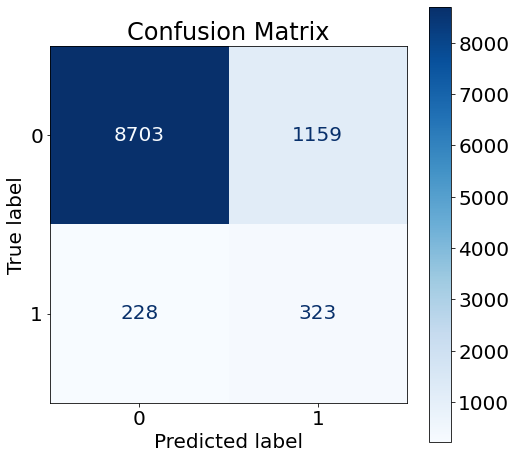

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(best_model, X, y, cmap= 'Blues', 
                  values_format='d', ax=ax );
plt.title('Confusion Matrix')
plt.savefig('../images/confusion_matrix.png')
plt.show()

*Confusion matrix plotted for Predicted and True Values for Class 1 (WNV Present) to Class 0 (No WNV Present) demonstrates the specificity and sensitivity of the model.*

In [41]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp/(fp+tp)

In [42]:
print("Sensitivity: ", round(sensitivity,2))
print("Specificity: ", round(specificity,2))
print("Precision:", round(precision,2))

Sensitivity:  0.59
Specificity:  0.88
Precision: 0.22


In this problem statement, the concern on the model prediction will be the false negative, also known as Type II error. With specificity/ recall at 0.88, and sensitivity at 0.59 the model is able to identify the true positive rate and true negative rate accordingly.

However, the precision score is low at 0.22 only. This means the model has been predicting cases as positive more than it should have been. 

### ROC AUC

In [43]:
TPR = sensitivity
print("True Positive Rate: ", round(TPR,2))
TNR = 1 - specificity
print("True Negative Rate (False Positive Rate)", round(TNR,2))

True Positive Rate:  0.59
True Negative Rate (False Positive Rate) 0.12


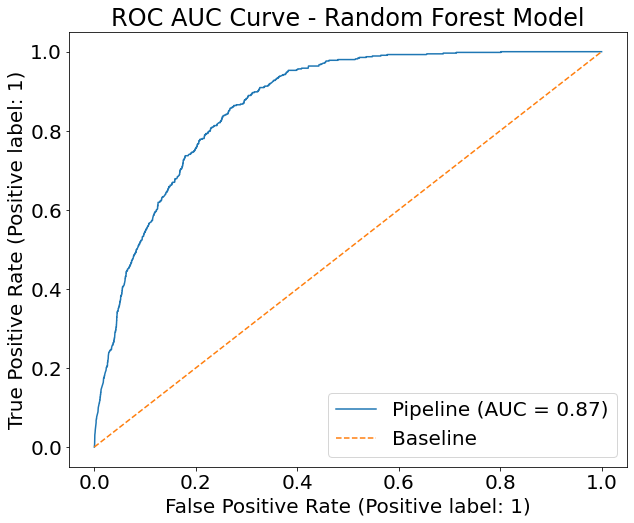

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(best_model,X,y,ax=ax)
plt.plot([0,1],[0,1], color='tab:orange', linestyle='--', label='Baseline')

plt.title('ROC AUC Curve - Random Forest Model')
plt.legend()
plt.savefig('../images/ROC_AUC.png')
plt.show()

### Model Threshold Adjustment

The model has a huge gap for improvement, in which the existing pipeline only has AUC of 0.87. Hence, we will look into the model prediction to observe the possible threshold changes.

In [46]:
#y_test vs predict proba
pred_prob_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': best_model.predict_proba(X_test)[:,1]})

pred_prob_df.head()

,true_values,pred_probs
4459,0,0.073130
4099,0,0.004542
4423,0,0.026527
521,0,0.029682
10393,0,0.224347


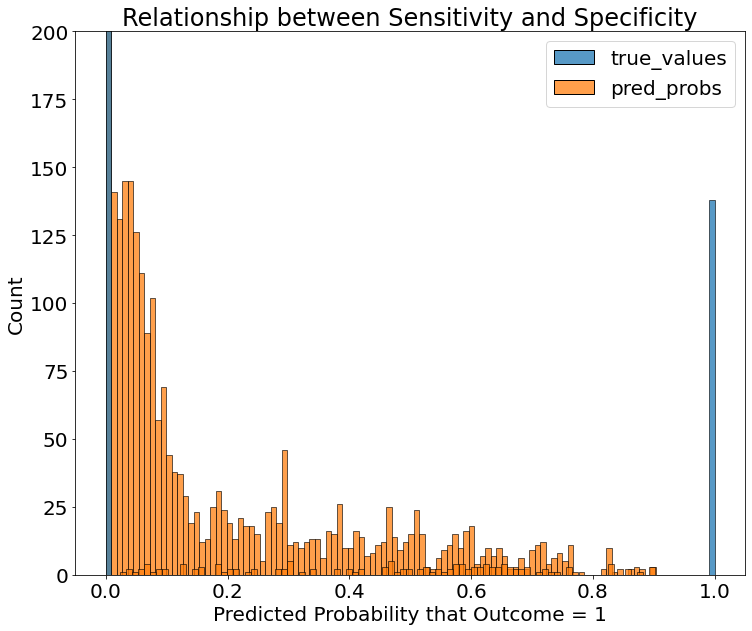

In [47]:
plt.figure(figsize = (12, 10))

# plot distributions of predicted probabilities by actual values
for group in pred_prob_df.groupby('true_values'):
    sns.histplot(group[1], kde = False, bins = 100)

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title('Relationship between Sensitivity and Specificity')
plt.ylim(0,200)
plt.show()

**Observation:** The overlap between the predictions are high and mostly inclined for 0 prediction. 

In [48]:
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [49]:
threshold_list = [0.45, 0.5, 0.55, 0.6]

for threshold in threshold_list:
    preds = get_predictions(best_model.predict_proba(X_test)[:,1], threshold)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f'Threshold: {threshold:.2f}, Recall: {rec:.2f}, Precision: {prec:.2f}, f1 : {f1:.2f}')

Threshold: 0.45, Recall: 0.60, Precision: 0.18, f1 : 0.28
Threshold: 0.50, Recall: 0.51, Precision: 0.20, f1 : 0.28
Threshold: 0.55, Recall: 0.45, Precision: 0.21, f1 : 0.29
Threshold: 0.60, Recall: 0.36, Precision: 0.23, f1 : 0.28


The threshold changes does not improve beyond the current model, of 0.22, however take a huge dive in the recall. In this matter, no changes on the threshold will be made on the existing model. 

### Feature Importance

In [50]:
best_rf

Pipeline(steps=[('ss', StandardScaler()),
                ('oversample', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [51]:
# Extracting feature importances
rf = RandomForestClassifier(max_depth=15, n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=150)

In [52]:
rf.feature_importances_

array([9.20967116e-02, 9.55841979e-02, 5.06781603e-03, 2.89058888e-03,
       6.74313232e-04, 1.34396092e-03, 2.31370524e-03, 6.66606030e-03,
       8.10066164e-04, 3.95241696e-03, 3.75961344e-03, 2.87473096e-03,
       2.69275796e-06, 1.78793906e-03, 6.65966873e-04, 1.07966433e-03,
       2.50896410e-04, 3.69793930e-05, 2.22163570e-03, 4.03968337e-03,
       6.75895920e-03, 3.07269653e-03, 5.55627723e-03, 3.02868244e-03,
       1.75154375e-03, 8.32501403e-03, 1.72366380e-03, 2.73766228e-03,
       5.91840162e-05, 1.25887113e-04, 1.40362744e-03, 1.16992849e-02,
       8.46185741e-03, 8.73927008e-03, 1.50752905e-02, 2.22777099e-04,
       6.72926719e-03, 7.90004731e-03, 8.40713171e-03, 2.18665155e-05,
       7.82208144e-04, 1.40707488e-03, 6.12538662e-03, 2.25842221e-05,
       7.42600058e-06, 3.39055051e-05, 5.88061250e-03, 3.53852462e-03,
       4.03979166e-03, 1.36880073e-04, 1.85844829e-03, 9.56623554e-04,
       2.27780963e-03, 4.65822038e-05, 3.17776950e-03, 2.98363684e-03,
      

In [53]:
df_fi = pd.DataFrame(zip(X.columns, rf.feature_importances_))

In [54]:
df_fi.head()

,0,1
0,latitude,0.092097
1,longitude,0.095584
2,street_ W ARMITAGE AVENUE,0.005068
3,street_ E 105TH ST,0.002891
4,street_ E 111TH ST,0.000674


In [56]:
df_fi.sort_values(by = 1, ascending = False).head(40)

,0,1
1,longitude,0.095584
0,latitude,0.092097
158,species_CULEX PIPIENS/RESTUANS,0.050847
157,species_CULEX PIPIENS,0.045814
144,daylightmins,0.033903
159,species_CULEX RESTUANS,0.028530
156,daylightminssq,0.026361
123,street_ W OHARE AIRPORT,0.016430
130,tmax,0.015719
34,street_ N OAK PARK AVE,0.015075


In [57]:
df_fi.sort_values(by = 1, ascending = True).head(10)

,0,1
64,street_ S HAMLIN AVE,0.000000
86,street_ S WALLACE ST,0.000001
78,street_ S RACINE AVE,0.000002
102,street_ W 85TH ST,0.000002
101,street_ W 77TH ST,0.000002
12,street_ E RANDOLPH ST,0.000003
124,street_ W PERSHING RD,0.000003
128,street_ W SUNNYSIDE AVE,0.000004
70,street_ S LONGWOOD DR,0.000006
44,street_ N STREETER DR,0.000007


The direct longitude and lattitude and the species are the critical features affecting the presence of WNV. We also observe the daylightmins also affecs the exposure for the mosquitos as well.

Other features like the street, we see top two street, Ohare Airport and Oak Park Avenue at the North area of Chicago streets that has higher odds in the exposure of WNV mosquitos.

This proves otherwise for the South area (Hamlin Ave, Wallace St, Racine Ave, 85th St, 77th St, Randolph St, Pershing Road, SunnySide Ave, Longwood Road, and Streeter Drive, making these locations WNV-free.

In [60]:
X_test = test_merged[X.columns]

In [61]:
kaggle_score = pd.DataFrame(zip(test_merged.id, gs.predict(X_test)))

In [62]:
kaggle_score.rename(columns = {0:"Id", 1: "WnvPresent"}, inplace = True)

In [63]:
kaggle_score.to_csv('../data/submission_3_street.csv', index= False)

## Conclusion